In [23]:
import copy, math
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from feature_engine.outliers import OutlierTrimmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

df = pd.read_csv('loan_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [3]:
df = df.drop(['person_emp_exp', 'cb_person_cred_hist_length', 'loan_percent_income', 'loan_int_rate'], axis=1)

In [4]:
df["person_age"] = df["person_age"].astype(int)
person_education = {'High School': 0,'Associate': 1,'Bachelor': 2,'Master': 3,'Doctorate':4}
gender_mapping = {'male': 0, 'female': 1}
home_ownership_mapping = {'RENT': 0, 'OWN': 1, 'MORTGAGE': 2, 'OTHER': 3}
loan_intent_mapping = {'PERSONAL': 0, 'EDUCATION': 1, 'MEDICAL': 2, 'VENTURE': 3, 'HOMEIMPROVEMENT': 4, 'DEBTCONSOLIDATION': 5}
previous_loan_defaults_mapping = {'No': 0, 'Yes': 1}

df['person_education'] = df['person_education'].map(person_education)
df['person_gender'] = df['person_gender'].map(gender_mapping)
df['person_home_ownership'] = df['person_home_ownership'].map(home_ownership_mapping)
df['loan_intent'] = df['loan_intent'].map(loan_intent_mapping)
df['previous_loan_defaults_on_file'] = df['previous_loan_defaults_on_file'].map(previous_loan_defaults_mapping)

In [5]:
trimmer = OutlierTrimmer(capping_method='iqr', tail='right',variables= ['person_age', 'person_gender', 'person_education', 'person_income', 'person_home_ownership', 'loan_amnt','loan_intent', 'credit_score','previous_loan_defaults_on_file'])
df2 = trimmer.fit_transform(df)
df2.head()

,person_age,person_gender,person_education,person_income,person_home_ownership,loan_amnt,loan_intent,credit_score,previous_loan_defaults_on_file,loan_status
1,21,1,0,12282.0,1,1000.0,1,504,1,0
2,25,1,0,12438.0,2,5500.0,2,635,0,1
5,21,1,0,12951.0,1,2500.0,3,532,0,1
9,21,1,0,12739.0,1,1600.0,3,640,0,1
11,21,1,1,13113.0,1,4500.0,4,651,0,1


In [6]:
skewed_cols = ['person_age', 'person_income','loan_amnt', 'credit_score']
ss = StandardScaler()

In [7]:
df2[skewed_cols] = ss.fit_transform(df2[skewed_cols])
df2.head()

,person_age,person_gender,person_education,person_income,person_home_ownership,loan_amnt,loan_intent,credit_score,previous_loan_defaults_on_file,loan_status
1,-1.345671,1,0,-1.796102,1,-1.524954,1,-2.533591,1,0
2,-0.407572,1,0,-1.791175,2,-0.611806,2,0.079621,0,1
5,-1.345671,1,0,-1.774973,1,-1.220571,3,-1.975042,0,1
9,-1.345671,1,0,-1.781668,1,-1.403201,3,0.179362,0,1
11,-1.345671,1,1,-1.769856,1,-0.814728,4,0.398792,0,1


In [8]:
df2[skewed_cols] = ss.transform(df2[skewed_cols])
df2.head()

,person_age,person_gender,person_education,person_income,person_home_ownership,loan_amnt,loan_intent,credit_score,previous_loan_defaults_on_file,loan_status
1,-6.586287,1,0,-2.184074,1,-1.728185,1,-12.638015,1,0
2,-6.366279,1,0,-2.184074,2,-1.728000,2,-12.585886,0,1
5,-6.586287,1,0,-2.184073,1,-1.728123,3,-12.626873,0,1
9,-6.586287,1,0,-2.184073,1,-1.728160,3,-12.583897,0,1
11,-6.586287,1,1,-2.184073,1,-1.728041,4,-12.579519,0,1


In [21]:
X = df2.drop(columns=['loan_status'])
Y = df2['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()
y_train_array = y_train.to_numpy()
y_test_array = y_test.to_numpy()


In [10]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [20]:
def compute_gradient_logistic(X, y, w, b):
    """
    Computes the gradient for logistic regression

    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters
      b (scalar)      : model parameter
    Returns
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w.
      dj_db (scalar)      : The gradient of the cost w.r.t. the parameter b.
    """
    m,n = X.shape
    dj_dw = np.zeros((n,))
    dj_db = 0.

    # for i in range(m):
    #     f_wb_i = sigmoid(np.dot(X[i],w) + b)
    #     # print("f_wb_i", f_wb_i)                                     #(n,)(n,)=scalar
    #     err_i  = f_wb_i  - y[i]                     #scalar
    #     for j in range(n):
    #         dj_dw[j] = dj_dw[j] + err_i * X[i,j]      #scalar
    #     dj_db = dj_db + err_i
    # dj_dw = dj_dw/m                                   #(n,)
    # dj_db = dj_db/m                                   #scalar
    z = np.dot(X, w) + b
    f_wb = sigmoid(z)  # (m,)
    error = f_wb - y                  # (m,)
    dj_dw = np.dot(X.T, error) / m     # (n,)  -> Uses matrix multiplication instead of loops
    dj_db = np.sum(error) / m          # Scalar

    return dj_db, dj_dw

In [21]:
w_tmp = np.zeros(9)
b_tmp = 1.
dj_db_tmp, dj_dw_tmp = compute_gradient_logistic(X_train_array, y_train_array, w_tmp, b_tmp)
print(f"dj_db: {dj_db_tmp}" )
print(f"dj_dw: {dj_dw_tmp.tolist()}" )


dj_db: 0.5099170378058432
dj_dw: [-3.1950188464842677, 0.22979738706986272, 0.7104160539702781, -1.1136637116679942, 0.5244678892431833, -0.8810807077285424, 1.1325963933640777, -6.418504260058619, 0.3759843438532549]


In [22]:
def compute_cost_logistic(X, y, w, b):
    """
    Computes cost

    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters
      b (scalar)       : model parameter

    Returns:
      cost (scalar): cost
    """

    m = X.shape[0]
    cost = 0.0
    for i in range(m):
        z_i = np.dot(X[i],w) + b
        f_wb_i = sigmoid(z_i)
        cost +=  -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)

    cost = cost / m
    return cost

In [23]:
def gradient_descent(X, y, w_in, b_in, alpha, num_iters):
    """
    Performs batch gradient descent

    Args:
      X (ndarray (m,n)   : Data, m examples with n features
      y (ndarray (m,))   : target values
      w_in (ndarray (n,)): Initial values of model parameters
      b_in (scalar)      : Initial values of model parameter
      alpha (float)      : Learning rate
      num_iters (scalar) : number of iterations to run gradient descent

    Returns:
      w (ndarray (n,))   : Updated values of parameters
      b (scalar)         : Updated value of parameter
    """
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in

    for i in range(num_iters):
        # Calculate the gradient and update the parameters
        dj_db, dj_dw = compute_gradient_logistic(X, y, w, b)

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion
            J_history.append( compute_cost_logistic(X, y, w, b) )

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")

    return w, b, J_history         #return final w,b and J history for graphing


In [24]:
df2.isnull().sum()
w_tmp = array_of_zeros = np.zeros(9)
b_tmp = 1.
alph = 0.1
iters = 10000
w_out, b_out, _ = gradient_descent(X_train_array, y_train_array, w_tmp, b_tmp, alph, iters)
print(f"\nupdated parameters: w:{w_out}, b:{b_out}")

Iteration    0: Cost 2.2006654274555886   
Iteration 1000: Cost 0.4397716703743892   
Iteration 2000: Cost 0.41237788210852305   
Iteration 3000: Cost 0.40388644287820274   
Iteration 4000: Cost 0.39976520119896997   
Iteration 5000: Cost 0.3973236769399358   
Iteration 6000: Cost 0.3957086723663271   
Iteration 7000: Cost 0.3945630683934317   
Iteration 8000: Cost 0.3937099195908194   
Iteration 9000: Cost 0.3930511103384245   

updated parameters: w:[-0.43712238 -0.03245534 -0.11918151  0.17835092 -0.94733786  0.14880933
  0.14915072  0.32465764 -6.78881329], b:0.9174657458675807


In [11]:
w_out = [-0.43712238, -0.03245534, -0.11918151,  0.17835092, -0.94733786,  0.14880933,
  0.14915072,  0.32465764, -6.78881329]
b = 0.9174657458675807



In [15]:
# X_test_array = X_test.to_numpy()
# y_test_array = y_test.to_numpy()
z = np.dot(X_test_array, w_out) + b
y_pred_probs = sigmoid(z)
y_pred = (y_pred_probs >= 0.5).astype(int)
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(7815,))

In [17]:
y_test_array

array([0, 0, 0, ..., 1, 0, 0], shape=(7815,))

In [16]:
accuracy = np.mean(y_pred == y_test_array) * 100  # Convert to percentage
print(f"Model Accuracy: {accuracy:.2f}%")

Model Accuracy: 77.85%


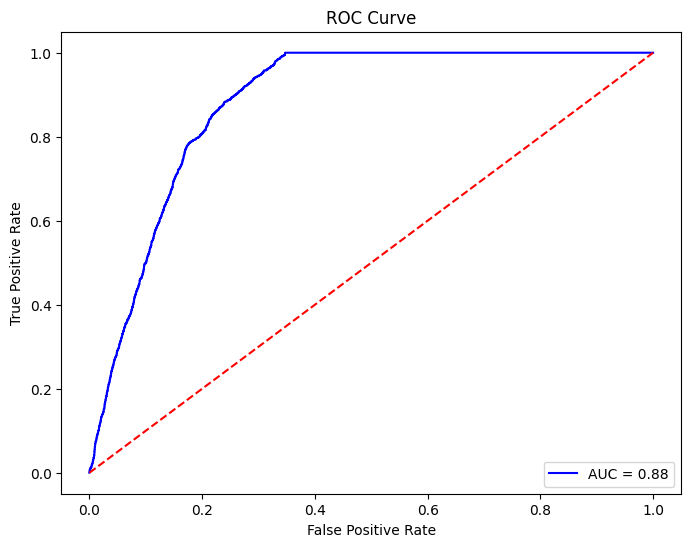

In [24]:
fpr, tpr, _ = roc_curve(y_test_array, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "r--")  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()